In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import sys

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
df = pd.read_csv("ratings.csv")

df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
df.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


In [6]:
df.userId.nunique(), df.movieId.nunique()

(610, 9724)

In [7]:
df.rating.value_counts()

,count
rating,
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791


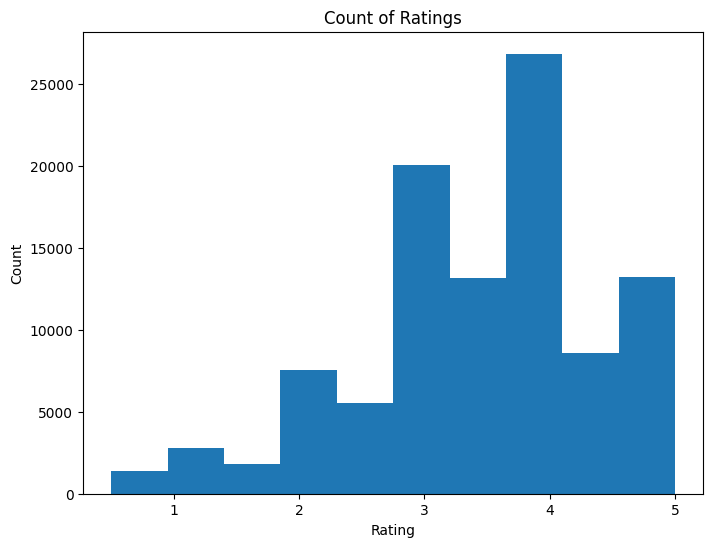

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(df.rating)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Ratings")
plt.show()

In [9]:
class MovieLensDataset(Dataset):
    """
    The Movie Lens Dataset class. This class prepares the dataset for training and validation.
    """

    def __init__(self, users, movies, ratings):
        """
        Initializes the dataset object with user, movie, and rating data.
        """
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.users)

    def __getitem__(self, item):
        """
        Retrieves a sample from the dataset at the specified index.
        """
        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.float),
        }

In [10]:
class RecommendationSystemModel(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        embedding_size=256,
        hidden_dim=256,
        dropout_rate=0.2,
    ):
        super(RecommendationSystemModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.movie_embedding = nn.Embedding(
            num_embeddings=self.num_movies, embedding_dim=self.embedding_size
        )

        # Hidden layers
        self.fc1 = nn.Linear(2 * self.embedding_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, users, movies):
        # Embeddings
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        # Pass through hidden layers with ReLU activation and dropout
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)

        return output

In [11]:
le_user = preprocessing.LabelEncoder()
le_movie = preprocessing.LabelEncoder()
df.userId = le_user.fit_transform(df.userId.values)
df.movieId = le_movie.fit_transform(df.movieId.values)

df_train, df_val = model_selection.train_test_split(
    df, test_size=0.1, random_state=3, stratify=df.rating.values
)

train_dataset = MovieLensDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values,
)

valid_dataset = MovieLensDataset(
    users=df_val.userId.values,
    movies=df_val.movieId.values,
    ratings=df_val.rating.values,
)

In [13]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
recommendation_model = RecommendationSystemModel(
    num_users=len(le_user.classes_),
    num_movies=len(le_movie.classes_),
    embedding_size=64,
    hidden_dim=128,
    dropout_rate=0.1,
).to(device)

optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [15]:
EPOCHS = 2


# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch+1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)

In [16]:
total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(
            train_data["users"].to(device), train_data["movies"].to(device)
        )
        # Reshape the model output to match the target's shape
        output = output.squeeze()  # Removes the singleton dimension
        ratings = (
            train_data["ratings"].to(torch.float32).to(device)
        )  # Assuming ratings is already 1D

        loss = loss_func(output, ratings)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step count by the actual size of the batch
        step_count += len(train_data["users"])

        # Check if it's time to log progress
        if (
            step_count % log_progress_step == 0 or i == len(train_loader) - 1
        ):  # Log at the end of each epoch
            log_progress(
                e, step_count, total_loss, log_progress_step, train_dataset_size, losses
            )
            total_loss = 0


Training on 90752 samples...


02/02 | Step: 90752/90752 | Avg Loss: 0.094164308

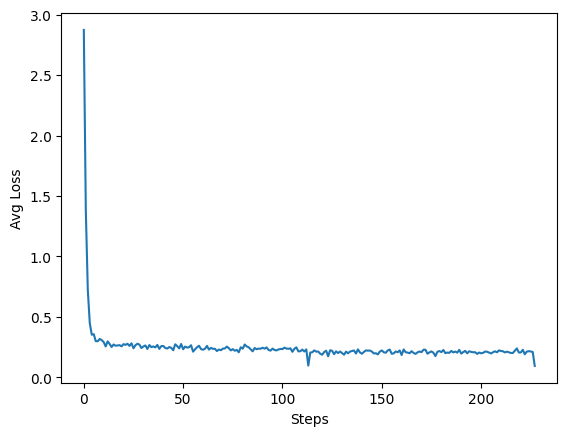

In [17]:
plt.figure()
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Avg Loss")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

y_pred = []
y_true = []

recommendation_model.eval()

with torch.no_grad():
    for i, valid_data in enumerate(val_loader):
        output = recommendation_model(
            valid_data["users"].to(device), valid_data["movies"].to(device)
        )
        ratings = valid_data["ratings"].to(device)
        y_pred.extend(output.cpu().numpy())
        y_true.extend(ratings.cpu().numpy())

# Calculate MSE and then take the square root to get RMSE
mse = mean_squared_error(y_true, y_pred)  # Remove squared=False
rms = np.sqrt(mse)  # Calculate RMSE manually
print(f"RMSE: {rms:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


RMSE: 0.9090


In [21]:
from collections import defaultdict


def calculate_precision_recall(user_ratings, k, threshold):
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
    n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
    n_rel_and_rec_k = sum(
        (true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k]
    )

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precision, recall


user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in val_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["movies"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model(users, movies)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 50
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [22]:
average_precision = sum(prec for prec in user_precisions.values()) / len(
    user_precisions
)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(
    user_based_recalls
)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 50: 0.8921
recall @ 50: 0.8597


In [24]:
def recommend_top_movies(model, user_id, all_movies, seen_movies, device, k=5, batch_size=100):
    model.eval()
    unseen_movies = [m for m in all_movies if m not in seen_movies]
    predictions = []

    with torch.no_grad():
        for i in range(0, len(unseen_movies), batch_size):
            batch_unseen_movies = unseen_movies[i:i+batch_size]
            user_tensor = torch.tensor([user_id] * len(batch_unseen_movies)).to(device)
            movie_tensor = torch.tensor(batch_unseen_movies).to(device)
            predicted_ratings = model(user_tensor, movie_tensor).view(-1).tolist()
            predictions.extend(zip(batch_unseen_movies, predicted_ratings))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
    return top_k_movies

def get_movies_with_genres(movie_ids, df_movies):
    # Select the relevant movies and create a new DataFrame
    movies_with_genres = df_movies[df_movies['movieId'].isin(movie_ids)].copy()
    # Concatenate movie titles with their genres
    movies_with_genres['title_with_genres'] = movies_with_genres[['title', 'genres']].agg(' - '.join, axis=1)
    return movies_with_genres['title_with_genres'].tolist()

# Load movie titles and genres
df_movies = pd.read_csv("movies.csv")

# Prepare all_movies and seen_movies
all_movies = df['movieId'].unique().tolist()
user_id = 1 # A random userId
seen_movies = set(df[df['userId'] == user_id]['movieId'].tolist())

# Get recommendations
recommendations = recommend_top_movies(
    recommendation_model, user_id, all_movies, seen_movies, device
)

# Get movie titles with genres for recommended and seen movies
recommended_movies_with_genres = get_movies_with_genres(recommendations, df_movies)

# For the user's top 10 rated seen movies, get movies with genres
user_top_ten_seen_movies = df[df['userId'] == user_id].sort_values(by="rating", ascending=False).head(10)
seen_movies_with_genres = get_movies_with_genres(user_top_ten_seen_movies['movieId'], df_movies)

print(f"Recommended movies:\n\n{recommended_movies_with_genres}\n\nbased on these movies the user has watched:\n\n{seen_movies_with_genres}")

Recommended movies:

['North by Northwest (1959) - Action|Adventure|Mystery|Romance|Thriller', "Felicia's Journey (1999) - Thriller", 'Zelig (1983) - Comedy']

based on these movies the user has watched:

['High Noon (1952) - Drama|Western', 'Hannah and Her Sisters (1986) - Comedy|Drama|Romance', 'After Hours (1985) - Comedy|Thriller', 'AVP: Alien vs. Predator (2004) - Action|Horror|Sci-Fi|Thriller']
